In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics

In [2]:
# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

In [3]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

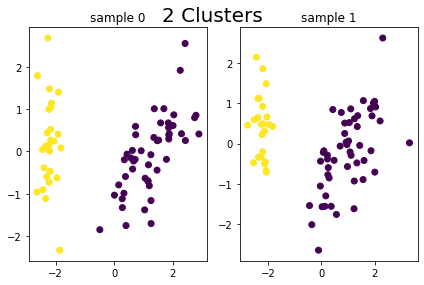

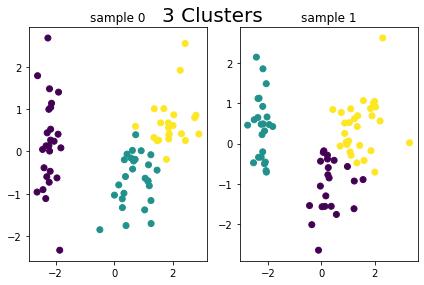

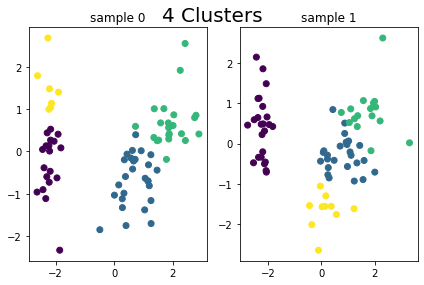

In [4]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [5]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)

pd.crosstab(y, full_pred) 

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,39,11
2,0,14,36


In [6]:
# must correct the above crosstab

full_pred = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred])

pd.crosstab(y, full_pred) 

col_0,0,1,2
row_0,,,
0,0,50,0
1,39,0,11
2,14,0,36


Now, we can read it more clearly. It seems that, all of the observations that belong to class 0 are assigned to the same cluster labeled with 0. This is great! However, remember that this class is the one that is linearly separable from the other two. Moreover, our k-means solution mistakenly assigns 14 of the observations that belong to class 1 to cluster 2 and 11 of the observations that belong to class 2 to the cluster 1. So out of 150 observations, 25 of the data points seem to be assigned to the wrong clusters. Well, not horrible, but not amazing.

In [7]:
def rand_index_score(ground_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(predictions), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(ground_truths), 2).sum()
    A = np.c_[(ground_truths, predictions)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(ground_truths))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [8]:
rand_index_score(y, full_pred)

0.8322147651006712

In [9]:
metrics.adjusted_rand_score(y, full_pred)

0.6201351808870379

In [10]:
# for when we don't have ground truth or labels which we do here but just for fun -1 is bad and 1 is good. 

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.45994823920518635


In [12]:
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.5817500491982808


In this case, going from 3 cluster to 2, the within cluster mean grew in the cluster that used to be 2 clustes making the silhouette coeff denominator increase and the overall ratio increase. 

In [14]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

In [15]:
conn_str = f"postgresql://{postgres_user}:{postgres_pw}@{postgres_host}:{postgres_port}/{postgres_db}"

query = """
SELECT *
FROM heartdisease
"""

df = pd.read_sql_query(query, con=conn_str)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [29]:
# Define the features and the outcome
X = df.iloc[1:, :13]
y = df.iloc[1:, 13]

# Replace missing values (marked by `?`) with a `0`
X = X.replace(to_replace='?', value=0)

# Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
y = np.where(y > 0, 0, 1)

In [30]:
X.shape

(302, 13)

1. Split the data randomly into two. Apply k-means using two, three, and four as the number of clusters, as you did when you were exploring consistency earlier in this checkpoint. Assess the consistency of the solutions using visualization. Which one seems to be the best?
2. Apply k-means on the whole dataset by setting k equal to 2, 3, and 4. Get the ARI score for each of them. Which model is best?
3. Apply k-means on the whole dataset by setting k equal to 2, 3, and 4. Get the silhouette coefficient for each of them. Which model is best?

In [31]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

In [32]:
X_pcahalf2.shape

(151, 2)

In [33]:
X_pcahalf1.shape

(151, 2)

In [34]:
X_half2.shape

(151, 13)

In [35]:
X_half1.shape

(151, 13)

In [36]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

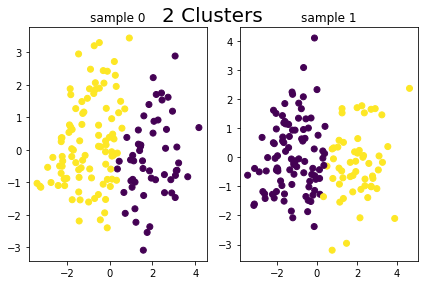

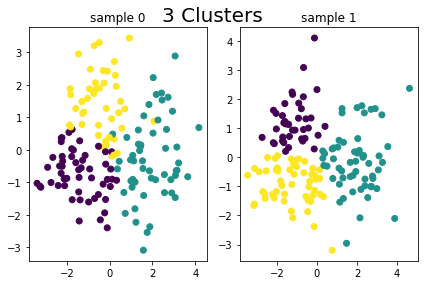

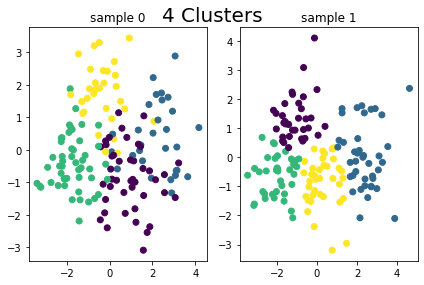

In [37]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [38]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)

In [39]:
rand_index_score(y, full_pred)

0.6431761677410838

In [40]:
metrics.adjusted_rand_score(y, full_pred)

0.2870229567629351

In [42]:
full_pred = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)

In [43]:
rand_index_score(y, full_pred)

0.7227783767133836

In [44]:
metrics.adjusted_rand_score(y, full_pred)

0.44545609632673205

In [45]:
full_pred = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

In [46]:
rand_index_score(y, full_pred)

0.6043871421970913

In [47]:
metrics.adjusted_rand_score(y, full_pred)

0.2098544292324814

### It appears that k=2 achieves the highest RI and ARI score so 2 clusters is best. 

In [48]:
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.17617692225171439


In [49]:
labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.13040917170304717


In [50]:
labels = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.13248288970951322


### K=2 also is best according to the silhouette coefficient. 